In [49]:
# Libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Section I - Data Preparation


### Step #1
Read test and control data

In [8]:
dataframe_control = pd.read_excel("data/ab_testing.xlsx" , sheet_name="Control Group")
dataframe_test = pd.read_excel("data/ab_testing.xlsx" , sheet_name="Test Group")

df_control = dataframe_control.copy()
df_test = dataframe_test.copy()

### Step #2

Analyze control and test group

In [9]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [10]:
check_df(df_control)

##################### Shape #####################
(40, 4)
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
    Impression      Click  Purchase    Earning
0  82529.45927 6090.07732 665.21125 2311.27714
1  98050.45193 3382.86179 315.08489 1742.80686
2  82696.02355 4167.96575 458.08374 1797.82745
3 109914.40040 4910.88224 487.09077 1696.22918
4 108457.76263 5987.65581 441.03405 1543.72018
##################### Tail #####################
     Impression      Click  Purchase    Earning
35 132064.21900 3747.15754 551.07241 2256.97559
36  86409.94180 4608.25621 345.04603 1781.35769
37 123678.93423 3649.07379 476.16813 2187.72122
38 101997.49410 4736.35337 474.61354 2254.56383
39 121085.88122 4285.17861 590.40602 1289.30895
##################### NA #####################
Impression    0
Click         0
Purchase      0
Earning       0
dtype: int6

In [11]:
check_df(df_test)

##################### Shape #####################
(40, 4)
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
    Impression      Click  Purchase    Earning
0 120103.50380 3216.54796 702.16035 1939.61124
1 134775.94336 3635.08242 834.05429 2929.40582
2 107806.62079 3057.14356 422.93426 2526.24488
3 116445.27553 4650.47391 429.03353 2281.42857
4 145082.51684 5201.38772 749.86044 2781.69752
##################### Tail #####################
     Impression      Click  Purchase    Earning
35  79234.91193 6002.21358 382.04712 2277.86398
36 130702.23941 3626.32007 449.82459 2530.84133
37 116481.87337 4702.78247 472.45373 2597.91763
38  79033.83492 4495.42818 425.35910 2595.85788
39 102257.45409 4800.06832 521.31073 2967.51839
##################### NA #####################
Impression    0
Click         0
Purchase      0
Earning       0
dtype: int6

### Step #3

Concatenate Control & Test group

In [12]:
df_control["group"] = "control"
df_test["group"] = "test"

df = pd.concat([df_control,df_test], axis=0,ignore_index=False)
df.head()

,Impression,Click,Purchase,Earning,group
0,82529.45927,6090.07732,665.21125,2311.27714,control
1,98050.45193,3382.86179,315.08489,1742.80686,control
2,82696.02355,4167.96575,458.08374,1797.82745,control
3,109914.40040,4910.88224,487.09077,1696.22918,control
4,108457.76263,5987.65581,441.03405,1543.72018,control


In [41]:
AB = pd.DataFrame()

AB["A"] = df[df['group'] == 'control']['Purchase']
AB["B"] = df[df['group'] == 'test']['Purchase']

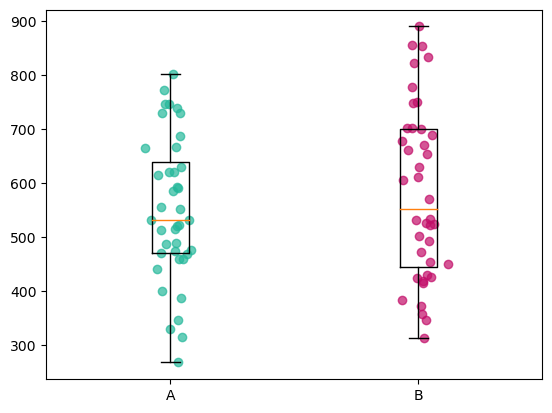

In [43]:
vals, names, xs = [],[],[]
for i, col in enumerate(AB.columns):
    vals.append(AB[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, AB[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
plt.boxplot(vals, labels=names)
palette = ['#25B89B', '#C20E69']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.7, color=c)
plt.show()

# Section II - AB Testing

### Step #1
Define AB Test Hypothesis

- H0 : M1 = M2 (There is no difference between the mean purchase of the control group and the test group)
- H1 : M1!= M2 (There is a difference between the mean purchase of the control group and the test group)

### Step #2
Analyze the mean purchase for the control and test group


In [13]:
df.groupby("group").agg({"Purchase": "mean"})

,Purchase
group,
control,550.89406
test,582.10610


# Section III - Performing Hypothesis Testing

### Step #1:
Make assumption checks before conducting hypothesis testing.

These are the Assumption of Normality and Homogeneity of Variance.

---
### Assumption of Normality:
- H0: The assumption of normal distribution is provided.
- H1: Assumption of normal distribution is not provided

---

- **p < 0.05** H0 Reject
- **p > 0.05** H0 Cannot reject

In [15]:
test_stat, pvalue = shapiro(df.loc[df["group"] == "control", "Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# p-value=0.5891
# HO cannot be rejected. The values of the Control group fulfill the assumption of normal distribution.

Test Stat = 0.9773, p-value = 0.5891


### Step #2

### Homogeneity of Variance:


- H0: Variances are homogeneous.
- H1: Variances are not homogeneous.

---

- **p < 0.05** H0 Reject
- **p > 0.05** H0 Cannot reject

In [17]:
test_stat, pvalue = levene(df.loc[df["group"] == "control", "Purchase"],
                           df.loc[df["group"] == "test", "Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

# p-value=0.1083
# HO cannot be rejected. The values of Control and Test group satisfy the assumption of variance homeogeneity.

Test Stat = 2.6393, p-value = 0.1083


### Step #3

Select the appropriate test according to the results of the assumption 

Since the assumptions are satisfied, an independent two sample t-test (parametric test) is performed.
- H0: M1 = M2 (There is no statistically significant difference between the control group and test group purchase averages)
- H1: M1 != M2 (There is a statistically significant difference between the control group and test group purchase averages)
---
- **p < 0.05** H0 Reject
- **p > 0.05** H0 Cannot reject

In [20]:
test_stat, pvalue = ttest_ind(df.loc[df["group"] == "control", "Purchase"],
                              df.loc[df["group"] == "test", "Purchase"],
                              equal_var=True)

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -0.9416, p-value = 0.3493


### Step #4

p-value > 0.05

HO cannot be rejected.

There is no statistically significant difference between control and test group purchase averages.

# Section IV - Website Click Through Rate Analysis (CTR)

It is a rate that shows how often users who saw the ad CLICKED the ad.

Ad Clicks / Ad Shows

In [ ]:
df.loc[df["group"] == "control", "Impression"]

In [44]:
control_CTR=df.loc[df["group"] == "control", "Click"].sum()/df.loc[df["group"] == "control", "Impression"].sum()
test_CTR=df.loc[df["group"] == "test", "Click"].sum()/df.loc[df["group"] == "test", "Impression"].sum()

print(control_CTR)
print(test_CTR)

0.05014831092596444
0.032922333085396625


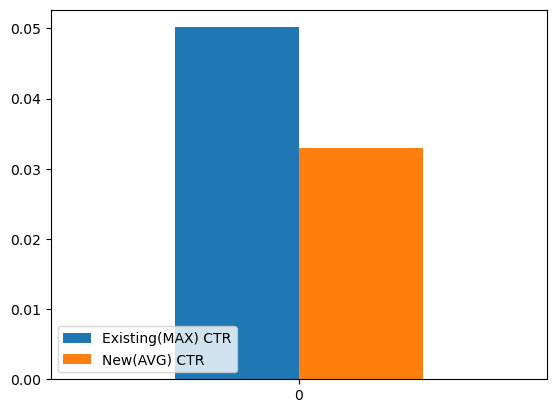

In [45]:
df_CTR = pd.DataFrame({"Existing(MAX) CTR":[control_CTR], "New(AVG) CTR": [test_CTR]})
df_CTR.plot.bar(rot=0).legend(loc=3) ;

### Hypothesis
- Ho: The experiment has no effect on user behavior. (p_cont = p_test)
- H1: The experiment has an effect on user behavior. (p_cont ≠ p_test)

In [51]:
clicks= np.array([df.loc[df["group"] == "control", "Click"].sum(),df.loc[df["group"] == "test", "Click"].sum()])
shows= np.array([df.loc[df["group"] == "control", "Impression"].sum(),df.loc[df["group"] == "test", "Impression"].sum()])
proportions_ztest(count=clicks, nobs=shows)

(129.3304801715903, 0.0)

**Report:**

p - value < 0.05

Reject Ho hypthesis. ( The experiment has no effect on user behavior. )

When the bidding methods are examined, the effect of these methods on user behavior (clicks) is different.

And this difference is in favor of the current "max bidding" method.

---

# Section V - Conversion Rate

Conversion rate is calculated by dividing the **number of conversions** by the **total number of visitors**.

For example, if an ecommerce site gets **200 visitors** a month and has 50 sales, the conversion rate would equal 25%

In [ ]:
df.loc[df["group"] == "control", "Purchase"]

In [53]:
control_CR = df.loc[df["group"] == "control", "Purchase"].sum()/df.loc[df["group"] == "control", "Impression"].sum()
test_CR = df.loc[df["group"] == "test", "Purchase"].sum()/df.loc[df["group"] == "test", "Impression"].sum()

print("Max Bidding CR:", round(control_CR,4))
print("AVG Bidding CR:", round(test_CR,4))

Max Bidding CR: 0.0054
AVG Bidding CR: 0.0048


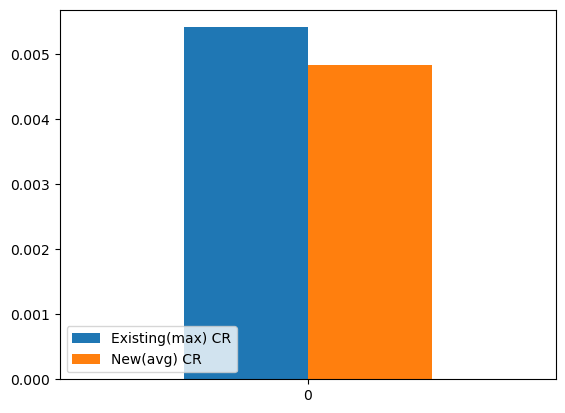

In [54]:
df_CR=pd.DataFrame({"Existing(max) CR":[control_CR], "New(avg) CR": [test_CR]})
df_CR.plot.bar(rot=0).legend(loc=3) ;

### Hypothesis
- Ho: The experiment has no effect on user behavior. (p_cont = p_test)
- H1: The experiment has an effect on user behavior. (p_cont ≠ p_test)

In [63]:
purchase= np.array([df.loc[df["group"] == "control", "Purchase"].sum(),df.loc[df["group"] == "test", "Purchase"].sum()])
impression= np.array([df.loc[df["group"] == "control", "Impression"].sum(),df.loc[df["group"] == "test", "Impression"].sum()])
proportions_ztest(count=purchase, nobs=impression)

(12.221173465876399, 2.39600929947382e-34)

**Report:**

p - value < 0.05

Reject Ho hypthesis. ( The experiment has no effect on user behavior. )

When the bidding methods are examined, the effect of these methods on user behavior (Purchasing) is different.

And this difference is in favor of the current "max bidding" method.

### Section VI - Project Report

- Control and test group data were analyzed.

- There is no NA value was observed in both groups.

- When looked with the boxplot method, it was observed that there was no outlier in both groups.


- Testing was done between these two groups.

  - Control group using the max bidding method as called A Test group using the new method,
  - Average bidding as called B


- Two independent samples t test was deemed appropriate for this comparison.

- For two independent samples t test; variance homogeneity and normality assumption were provided.


### Q: Is the new system advantageous?

As a result of the statistical tests applied to the data obtained by the two groups in the research, the groups **provided** all the necessary statistical assumptions in the literature.

In this direction, it was **proved** statistically and scientifically that there was **no significant difference** between the **averages** of the two groups with **95%** confidence.

In line with these results, **there is not statistically significant difference** between purchase of the control group (Max Bidding) and purchase of the test group (Average Bidding)

**The new method does not benefit your agency in terms of purchasin**

### Q: Did the user who saw the ad click on the ad in the new system?

There is a difference in **Clicking** between the two methods, but this is in favor of "**Maximum Bidding**", which is the system your agency **currently use**.

### Q: Did visitors buy the product in the new system?

There is a difference in Purchasing between the two methods, but this is in favor of "**Maximum Bidding**", which is the system your agency **currently use**.

--- 

### Advice:

As a result of the statistical tests carried out, the new system "Average Bidding" has not been observed to benefit your company.

**Some advice for action:**

- We recommend that you continue with the existing system.

- A new test can be done by increasing the number of samples.